### Why INCLINATION and SEMIMAJOR_AXIS
* Both require external force to change
* `SEMIMAJOR_AXIS` ignore variance in `APOAPSIS` and `PERIAPSIS`
* Both remains constant in an elliptical orbit
* Independent of each other
* `INCLINATION` remains fairly constant over long periods of time
* Note: `SEMIMAJOR_AXIS` decreases over time due to orbital decay.  In fact, a lot of maneuvers are orbit raising maneuvers to compensate for this.

### Problems encountered
* Data interval varies a lot - from 1 entry in 3 months to less than 2 hours between 2 TLEs
* Duplicates in data
* Some error in data (for example, random spikes)
* Due to different engine types, some maneuvers are quick (happens between 2 TLEs) and some takes place over a long time (2 weeks for some starlinks).
* The closeness of the satellite has a major and non-linear effect on its orbital decay rate
* Some satellites constantly maneuvers to stay in orbit (ie: starlink), some let it decay and does big boosts (ISS)
* It appears that `INCLINATION` suffers from periodic variance or just inaccuracies in measurement
* Solar activity causes increase variance in decay

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

import importlib
import detect_maneuver # put it in a .py so it can be used by the SOCRATES detection part also
importlib.reload(detect_maneuver);

In [2]:
path = f'../../../siads591 data/filtered_raw/payload.pkl.gz' # path to the data file
df = pd.read_pickle(path, compression="gzip")

In [3]:
satcat = pd.read_csv(f'../satcat_all.csv')

In [4]:
df = df.reset_index().sort_values(by=["NORAD_CAT_ID","EPOCH"]).drop_duplicates(subset=["NORAD_CAT_ID","EPOCH"]).set_index("EPOCH")

In [16]:
maneuver_functions = {
    'INCLINATION': [
        ("diff", lambda x:x - x.shift(), [0.002,0.005,0.008]),
#         ("neighbors_diff", lambda x:x.shift(-1) - x.shift(), [0.002,0.005,0.008]),
        ("rolling_4_neightor_diff", lambda x:x.rolling(4, min_periods=1).mean().shift(-3) - x.rolling(4, min_periods=1).mean(), [0.002,0.005,0.008]),
#         ("rolling_7_neightor_diff", lambda x:x.rolling(7, min_periods=1).mean().shift(-6) - x.rolling(7, min_periods=1).mean(), [0.002,0.005,0.008]),
        ("rolling_10_neightor_diff", lambda x:x.rolling(10, min_periods=1).mean().shift(-9) - x.rolling(10, min_periods=1).mean(), [0.002,0.005,0.008]),
        ("rolling_20_neightor_diff", lambda x:x.rolling(20, min_periods=1).mean().shift(-19) - x.rolling(20, min_periods=1).mean(), [0.002,0.005,0.008]),
    ],
    'SEMIMAJOR_AXIS': [
        ("diff", lambda x:x - x.shift(), [0.008, 0.025, 0.06]),
        ("neighbors_diff", lambda x:x.shift(-1) - x.shift(), [0.008, 0.025, 0.06]),
        ("rolling_3_neightor_diff", lambda x:x.rolling(3, min_periods=1).mean().shift(-2) - x.rolling(3, min_periods=1).mean(), [0.008, 0.025, 0.06]),
        ("rolling_5_neightor_diff", lambda x:x.rolling(5, min_periods=1).mean().shift(-4) - x.rolling(5, min_periods=1).mean(), [0.008, 0.025, 0.06]),
#         ("rolling_10_neightor_diff", lambda x:x.rolling(10, min_periods=1).mean().shift(-9) - x.rolling(10, min_periods=1).mean(), [0.008, 0.015, 0.06]),
    ],
}

combined_maneuver_functions = {
    'INCLINATION': [
        ("rolling_10_neightor_diff", lambda x:x.rolling(10, min_periods=1).mean().shift(-9) - x.rolling(10, min_periods=1).mean(), [0.008]),
    ],
    'SEMIMAJOR_AXIS': [
        ("rolling_3_neightor_diff", lambda x:x.rolling(3, min_periods=1).mean().shift(-2) - x.rolling(3, min_periods=1).mean(), [0.025]),
    ],
}

satellite_and_range = [
    (27424, slice(4300, 5500, None)), # AQUA 2008-10 to 2010-10
    (33053, slice(1700, 2150, None)), # FERMI single event April 2012
    (25544, slice(-2000, None, None)), # ISS past year
    (38337, slice(1500,2500,None)), # GCOM W1 2016-3 to 2017-09
    (40059, slice(1800,2200,None)), # OCO-2 2017-12 to 2018-05
    (22675, slice(None, None, None)), # COSMOS 2251 - no propulsion
    (39210, slice(100, 4000, None)), # PAYLOAD C - 2014 to 2019
    (44713, slice(None, None, None)), # STARLINK-1007 - 2019-11 to current
]

In [53]:
for norad_id, df_slice in tqdm(satellite_and_range):
    raw, fixed, maneuver_results, fig = detect_maneuver.plot_maneuver_results(df, satcat, norad_id, df_slice, maneuver_functions)
    plt.savefig(f'maneuver_analysis/{satcat.loc[(satcat.NORAD_CAT_ID == norad_id),"SATNAME"].values[0]} ({norad_id}).png', facecolor='white', transparent=False)
    plt.close()
    raw, fixed, maneuver_results, fig = detect_maneuver.plot_maneuver_results(df, satcat, norad_id, df_slice, combined_maneuver_functions, True)
    plt.savefig(f'maneuver_analysis/{satcat.loc[(satcat.NORAD_CAT_ID == norad_id),"SATNAME"].values[0]} ({norad_id})_combined.png', facecolor='white', transparent=False)
    plt.savefig(f'../../images/{norad_id}_maneuver_combined.png', facecolor='white', transparent=False)
    plt.close()

100%|██████████| 8/8 [00:27<00:00,  3.48s/it]


array([<AxesSubplot:xlabel='EPOCH'>, <AxesSubplot:xlabel='EPOCH'>],
      dtype=object)

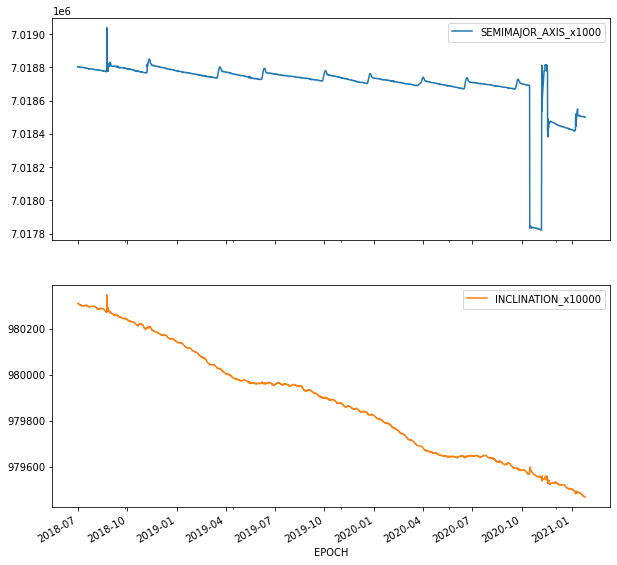

In [58]:
df[df.NORAD_CAT_ID==43259][['SEMIMAJOR_AXIS_x1000','INCLINATION_x10000']][300:].plot(subplots=True, figsize=(10,10))

array([<AxesSubplot:xlabel='EPOCH'>, <AxesSubplot:xlabel='EPOCH'>],
      dtype=object)

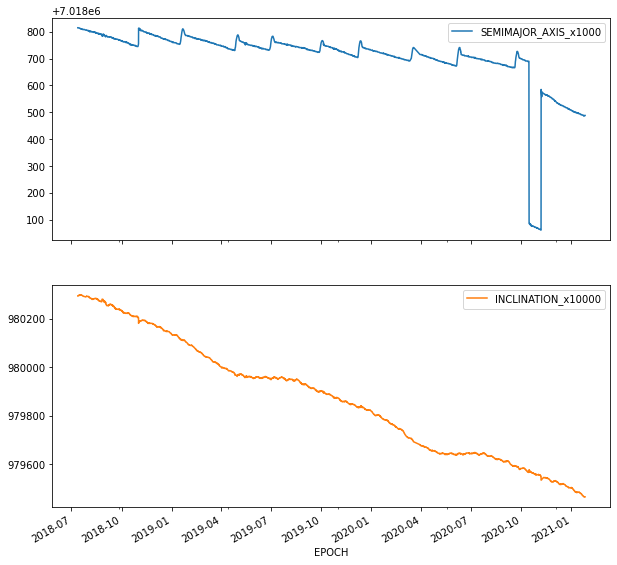

In [57]:
df[df.NORAD_CAT_ID==43260][['SEMIMAJOR_AXIS_x1000','INCLINATION_x10000']][300:].plot(subplots=True, figsize=(10,10))

array([<AxesSubplot:xlabel='EPOCH'>, <AxesSubplot:xlabel='EPOCH'>],
      dtype=object)

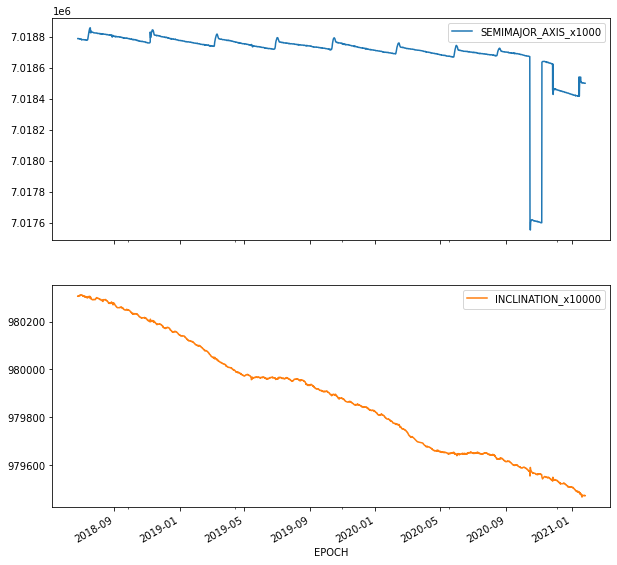

In [55]:
df[df.NORAD_CAT_ID==43262][['SEMIMAJOR_AXIS_x1000','INCLINATION_x10000']][300:].plot(subplots=True, figsize=(10,10))
